# Coursera Data Analysis

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import datetime as dt
import regex as re
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets
from scipy.stats import pearsonr

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
sns.set_style('whitegrid')

`Notes`: 
* Export the notebook to HTML 
* Average number of students per course.
* Plotly is way better for interactive charts

### Table of Contents
* Data Input & Preparation
* Exploratory Data Analysis
* Conclusions
* Improvement Points
* Appendix

***** 
## Data Input & Preparation

In [2]:
coursera_data = pd.read_csv('coursea_data.csv', index_col=0)
coursera_data.columns = coursera_data.columns.str.replace('course_', '')\
                                             .str.lower()
coursera_data.head()

,title,organization,certificate_type,rating,difficulty,students_enrolled
134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k
874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k
413,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k
635,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k


Let's capitalize the `difficulty` column to make it in line with the `certificate_type` column:

In [3]:
coursera_data.difficulty = coursera_data.difficulty.str.upper()

Notice, that the `students_enrolled` column has string values of the enrolled numbers of students for each course. Let's create raw numbers but before checking for all combinations of the string multipliers (e.g. k, m):

In [4]:
print(coursera_data.students_enrolled.str[-1].unique())

['k' 'm']


In [5]:
def students_timed(value):
    if value[-1] == 'k':
        return int(float(value[:-1]) * 1000)
    else:
        return int(float(value[:-1]) * 1000000)
    
coursera_data['students_enrolled'] = coursera_data.students_enrolled.apply(lambda x : students_timed(x))

Nice! We have the raw numbers for the `students_enrolled` variable. 

But if you notice, some organizations are official learning institutions (e.g. `University of Pennsylvania`), whereas others - companies that have released courses (e.g. (ISC)²). Let's create a dummy that indicates whether the institution is an official learning institution, or not (obviously, to the best of my knowledge):

In [6]:
coursera_data['official_learning_institution'] = coursera_data.organization.\
    str.contains('University|School|Universidad|École|INSEAD|Universitat|Università|Universidade|Sciences Po|College|HEC Paris|Universität')

coursera_data.head(1)

,title,organization,certificate_type,rating,difficulty,students_enrolled,official_learning_institution
134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,BEGINNER,5300,False


Lastly, what if the more courses the organization creates - the more succesfull their courses become due to the sheer experience of making courses. 

Let's create a column that would indicate how many courses an organization has in the Coursera database

In [7]:
def get_grouped_table(category_to_be_grouped_on, widget2_value, widget3_value = 10):

      renaming_dict = {'students_enrolled' : 'total_students_enrolled',
                       'rating' : 'mean_rating',
                       'title' : 'total_nr_of_courses'}

      grouped_table = coursera_data.groupby([category_to_be_grouped_on])\
            .agg({'students_enrolled' : 'sum',
                  'rating' : 'mean',
                  'title' : 'count'})
      
      
      if widget2_value == 'rating' and category_to_be_grouped_on == 'organization':
            grouped_table = grouped_table[grouped_table.title > 5]
      
      top_category_by_metric = grouped_table.sort_values(by = widget2_value, ascending=False).head(widget3_value)\
                                            .rename(renaming_dict, axis = 1)
      return top_category_by_metric, renaming_dict.get(widget2_value)

orgs_nr_of_courses = get_grouped_table('organization', 'title', 154)[0]

coursera_data = pd.merge(coursera_data,
                         orgs_nr_of_courses['total_nr_of_courses'],
                         how = 'inner',
                         left_on = 'organization', right_index = True)
coursera_data.head(3)

,title,organization,certificate_type,rating,difficulty,students_enrolled,official_learning_institution,total_nr_of_courses
134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,BEGINNER,5300,False,3
612,Access Controls,(ISC)²,COURSE,4.6,BEGINNER,2900,False,3
856,"Identifying, Monitoring, and Analyzing Risk an...",(ISC)²,COURSE,4.9,BEGINNER,1700,False,3


Having done initial data clean up, let's dive into the number of null, unique values

First, how many null values do we have for each column?

In [8]:
coursera_data.isna().sum()

title                            0
organization                     0
certificate_type                 0
rating                           0
difficulty                       0
students_enrolled                0
official_learning_institution    0
total_nr_of_courses              0
dtype: int64

Great! It seems we have no null values in any of the columns. What about unique titles for the names of the courses? If we have multiple courses that have the same name, we should use a `title`-`organization` axis to determine unique courses.

In [9]:
duplicated_titles = coursera_data[coursera_data.title.duplicated()].title.values
print(f"These are the duplicated titles: {duplicated_titles}.\nHere are their values:")
coursera_data[coursera_data.title.isin(duplicated_titles)]

These are the duplicated titles: ['Machine Learning' 'Developing Your Musicianship' 'Marketing Digital'].
Here are their values:


,title,organization,certificate_type,rating,difficulty,students_enrolled,official_learning_institution,total_nr_of_courses
6,Machine Learning,Stanford University,COURSE,4.9,MIXED,3200000,True,16
325,Marketing Digital,Universidad Austral,SPECIALIZATION,4.7,BEGINNER,39000,True,4
181,Machine Learning,University of Washington,SPECIALIZATION,4.6,INTERMEDIATE,290000,True,5
756,Developing Your Musicianship,Berklee College of Music,COURSE,4.8,MIXED,41000,True,14
205,Developing Your Musicianship,Berklee College of Music,SPECIALIZATION,4.8,BEGINNER,54000,True,14
241,Marketing Digital,Universidade de São Paulo,COURSE,4.8,BEGINNER,81000,True,3


From this, we can see that generally, all titles are unique bar the 3 titles stated above. However, two of these titles have different organizations that created the courses, which makes me think that we can treat these as separate courses (especially as the titles are generally broad and common e.g. "Marketing Digital"). However, we can't say the same about the `Developing Your Musicianship` course from `Berklee College of Music`. Although, they do have different `certificate_types` and `difficulties`, which indicates that they are separate courses. We will go with the latter assumption. Additionally, maybe this would be an interesting test case for identifying how `certificate_types` and `difficulties` affect `rating` & `students_enrolled` controlling for other values in the dataset.

What about the number of unique values in the other columns?

In [10]:
coursera_data.apply(lambda col : col.nunique())

title                            888
organization                     154
certificate_type                   3
rating                            14
difficulty                         4
students_enrolled                205
official_learning_institution      2
total_nr_of_courses               23
dtype: int64

Alright, we have 154 unique organizations that have created courses in this dataset. There are 3 & 4 unique values in the `certificate_type` and `difficulty` metrics, which correspond to the categories we will see later. There's 205 unique values for the enrolled students number, which makes sense. But interestingly, there's only 14 unique values for the `rating` metric. For a supposedly continuous variable, this lack of variety is surprising. This may create difficulties in extracting an unbiased quality metric from the `rating` variable. What about the distribution of the numeric metrics?

In [11]:
coursera_data.describe()
# coursera_data.describe(include='object')

,rating,students_enrolled,total_nr_of_courses
count,891.000000,8.910000e+02,891.000000
mean,4.677329,9.055208e+04,16.737374
std,0.162225,1.819365e+05,15.506887
min,3.300000,1.500000e+03,1.000000
25%,4.600000,1.750000e+04,5.000000
50%,4.700000,4.200000e+04,11.000000
75%,4.800000,9.950000e+04,22.000000
max,5.000000,3.200000e+06,59.000000


Firstly, since there are no null `rating` values, we can see that we have 891 total courses in the dataset. Secondly, the distribution of the `rating` metric might be a bit limited and our interpretation of the results from this rating should take into account the overreaching bias of people rating these courses once they finish them.

However, the `students_enrolled` column is harder to understand the distribution of. 
The `total_nr_of_courses` metric shows quite a variety in how many courses each organization is doing as well.
Can we visualize these distributions?

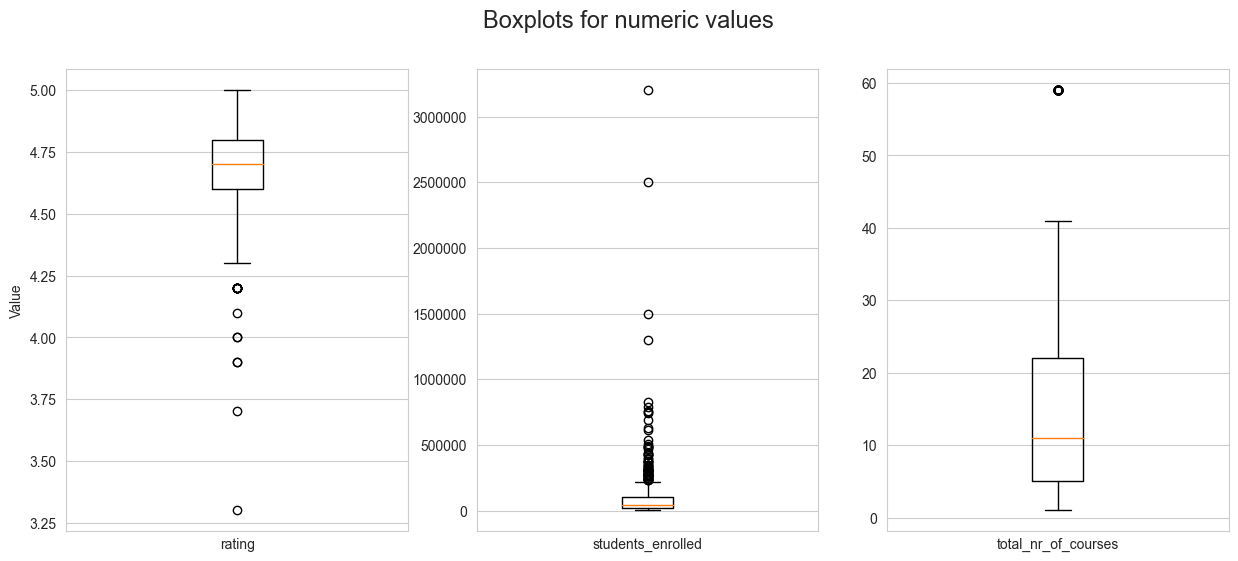

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (15, 6))

fig.suptitle('Boxplots for numeric values', fontsize = 17) # Better name - create titles for each boxplot
ax[0].boxplot(coursera_data.rating);
ax[0].set_xlabel('rating')
ax[0].set_xticks([])
ax[0].set_ylabel('Value')
ax[1].boxplot(coursera_data.students_enrolled);
ax[1].set_xlabel('students_enrolled')
ax[1].set_xticks([])
ax[1].ticklabel_format(style = 'plain', axis = 'y')
ax[2].boxplot(coursera_data.total_nr_of_courses);
ax[2].set_xticks([])
ax[2].set_xlabel('total_nr_of_courses');

From this we can see that the the `rating` value has a limited range of 3.25-5. The `students_enrolled` values are mostly below 1 mil. students. There are some outliers that reach above this 1 mil. threshold. We will discuss what to do with these outliers later. Whereas, the `total_nr_of_courses` metric has the 50% percentile of around 10, with one outlier of an organization creating around 60 courses. 

What are these outliers?

In [13]:
print(f"""The organization that creates the most courses:\
    {[*orgs_nr_of_courses.query('total_nr_of_courses > 50').index]}""")

coursera_data.query('students_enrolled > 1000000')

The organization that creates the most courses:    ['University of Pennsylvania']


,title,organization,certificate_type,rating,difficulty,students_enrolled,official_learning_institution,total_nr_of_courses
2,The Science of Well-Being,Yale University,COURSE,4.9,MIXED,2500000,True,17
47,Programming for Everybody (Getting Started wit...,University of Michigan,COURSE,4.8,MIXED,1300000,True,41
3,Python for Everybody,University of Michigan,SPECIALIZATION,4.8,BEGINNER,1500000,True,41
6,Machine Learning,Stanford University,COURSE,4.9,MIXED,3200000,True,16


Very impressive by the `University of Pennsylvania`. Removing them from the database, however, would be unwise - so we are going to leave these outliers in for now, since they do not show any problematic signs of the data being factually incorrect. Interestingly, the most popular courses, by student number are `COURSES` certification type & `MIXED` difficulty. Maybe some foreshadowing of these value combinations being important factors in the course being able to prosper.

P.s.: peep that 2 of these 4 most popular courses teach Python & another specifically targets `Machine Learning` :)

***** 
## Exploratory Data Analysis

Now that we have a short list of interesting findings, I believe it is imperative to understand the purpose of this analysis. The purpose of this analysis is to understand what makes courses successful on the Coursera platform? In our case, we will define "success" as the number of `students enrolled` in the course, firstly, & the `rating` of the course, secondarily. For `organizations`, the `enrolled students`, average `rating` & number of courses on the platform will define success. 

Alright, now that we have define what "success" looks like, why don't we look at these specific metrics compared by `organization`, `certificate_type`, `difficulty` & `official_learning_institution`? For this, we need an interactive bar chart builder:

In [14]:
barplot_columns = ['organization', 'certificate_type' , 'difficulty', 'official_learning_institution']

outliers_mask = 'students_enrolled > students_enrolled.quantile(0.996)'
outliers = coursera_data.query(outliers_mask)[['title', 'organization']]

widget1_bar = widgets.Select(options=barplot_columns,
                         value='organization',
                         description='Category',
                         disabled=False)

widget2_bar = widgets.Select(options = ['students_enrolled', 'rating', 'title'],
                         value = 'students_enrolled',
                         description = 'Value')

if widget1_bar.value == 'organization':
    widget3_bar = widgets.BoundedIntText(value=10,
                         min = 1,
                         max = 20,
                         description = 'Display',
                         disabled=False)

widget4_bar_save_figure = widgets.ToggleButton(
    value=False,
    description='Save Figure',
    disabled=False,
    button_style='info',
    tooltip='Description',
    icon=''
)

widget_5_bar_suffix = widgets.Text(
    placeholder='Type something',
    description='Suffix:',
    disabled=False   
)

def remove_borders():
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

def get_axis_labels(widget1_value, widget2_value):
    axis_labels = [None, None]

    if widget1_value == 'organization':
        axis_labels[0] =  'Organization'
    elif widget1_value == 'certificate_type':
        axis_labels[0] = 'Certificate Type'
    elif widget1_value == 'difficulty':
        axis_labels[0] = 'Difficulty'
    else: 
        axis_labels[0] = 'Official Learning Institution'
    
    if widget2_value == 'students_enrolled':
        axis_labels[1] =  'Total Enrolled Students'
    elif widget2_value == 'rating':
        axis_labels[1] =  'Average Rating'
    else: 
        axis_labels[1] =  'Nr Of Courses'
    
    return axis_labels[0], axis_labels[1]
    
    
def create_barplot(widget1_value, widget2_value, widget3_value, w4_save_bool, w5_suffix):
    plt.figure(figsize = (12, 6))
    grouped_table_by_choice, renamed_widget2_value = get_grouped_table(widget1_value, widget2_value, widget3_value)
    bars = sns.barplot(x = grouped_table_by_choice.index, y = grouped_table_by_choice[renamed_widget2_value],
                       mouseover = True)
    if widget2_value == 'rating' and widget1_value == 'organization':
        print("""Note: You have chosen to look at the rating & organization,\n\
        only organizations that had more than 5 courses in the dataset are displayed:""")
    
    for bar in bars.patches:

        height = bar.get_height()
        if widget2_value == 'rating':
            dropoff = 0.1
            label = f"{float(height):.2f}"
        elif widget2_value == 'students_enrolled':
            dropoff = 225000
            label = f"{int(height/1000)}k"
        else:
            dropoff = 2
            label = f"{int(height)}"
        plt.text(bar.get_x() + bar.get_width() / 2,
                 dropoff,
                 label,
                 ha='center', color='w', fontsize=8, fontweight = 'bold')
    
    remove_borders()
    
    xlbl, ylbl = get_axis_labels(widget1_value, widget2_value)
    plt.xticks(rotation = 90, fontsize = 8)
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.title(f'{ylbl} per {xlbl}')
    if w4_save_bool and w5_suffix:
        plt.savefig(f'barplot_{w5_suffix}', bbox_inches='tight');
        print(f"Figure saved as barplot_{w5_suffix}")
        widget4_bar_save_figure.value = False
    plt.show()
    

interactive_plot = interactive(create_barplot,
                               widget1_value = widget1_bar,
                               widget2_value = widget2_bar,
                               widget3_value = widget3_bar,
                               w4_save_bool = widget4_bar_save_figure,
                               w5_suffix = widget_5_bar_suffix);

widgets.VBox([interactive_plot])

From this point on, we will analyse the interesting observations we can extract from the this interactive window.

For example, let's look at the Nr of Courses per Organization:

In [15]:
%%html
<img src='barplot_courses_orgs.png'/>

Here we can see `University of Pennsylvania` taking the lead in the number of courses, which we have discovered previously. However, it's interesting to see that out of the top 10 organizations by `total_nr_of_courses` out, **8** are official learning institutions, which might make sense in the fact that official learning institutions have built up extensive experience in how to prepare courses of high quality and at a faster pace. Another interesting observation is that the successful organizations, at least according to the `total_nr_of_courses` variable, are pretty eavenly spread out, and not a significant amount of all courses are created by one organization, except for maybe `University of Pennsylvania`. 

Let's see if we'll see the same organizations when we look at `students_enrolled`:

In [16]:
%%html 
<img src='barplot_students_top_orgs.png'/>

Well, this is certainly surprising. Whilst, `University of Pennsylvania` in the number of courses on the platform comfortably beats second place `University of Michigan`, the latter apparently racks in more students. This might indicate them being better in suiting their courses to a specific audience. But the shining stars of this view are definitely `Stanford University` & `Yale University`. Owing to their historic name, they were not part of the top 10 organizations by nr of courses out, but are firmly placed in 3rd and 7th place according to `Total Enrolled Students`. This certainly hints towards some organizations being better at targeting their courses to specific audiences, making less, but more popular courses. Or is it related to higher perceived quality of the courses (aka `rating`)?

In [17]:
%%html 
<img src='barplot_rating_top_orgs.png'/>

Now, this is interesting - in this instance we lose the `Universities of Michigan and Pennsylvania` alltogether. This might hint towards them creating lots of courses, with relatively high popularity but which ultimately receive not great evaluations. However, the main observation is that a lot of the values that are left from the previous visuals are either: `Yale`, `Stanford`, or organizations that have little amount of courses, but high quality courses, which cannot yet fully be taken as an organization that has successfully secured it's market share on the platform. These three options indicate two possible ideas: established market players either **produce less courses, but more high quality ones** or **produce high amounts of courses that are individually of lesser quality.**

Here is when we finally see courses from organizations that are not from the US (`Universidad Nacional Autonoma de Mexico`, `Universita Bocconi`, `Universiteit Leiden`, `Macquaire University`) possibly hinting at courses created in other languages than English. 

Alright, let's dive deeper into the other categorical variables - shall we? E.g. `difficulty`. For more `difficult` courses we could possibly expect a lower enrollment rate and possibly a lower `rating` because of the increased difficulty.

In [18]:
%%html 
<img src='barplot_students_diff.png'/>

* Add a scatterplot per course to indicate how many courses we have per difficulty.

This is rather expected - the harder the difficulty, the less we see people enroll in the course, hence the lower enrollment rate. What about the average `rating`?

In [19]:
%%html 
<img src='barplot_rating_diff.png'/>

Alright, there is no significant difference between these average values. However, marginally we can state that the `MIXED` courses were the most well-received by the learner community, coming before `Beginner`, `INTERMEDIATE` & `ADVANCED` courses. Well, not many interesting findings from that - what about splitting the courses by `certificate_types`? 

In [20]:
%%html 
<img src='barplot_students_cert_type.png'/>

Alright, this reflects logic as well, since the `SPECIALIZATION`s & `PROFESSIONAL CERTIFICATE`s are more specialized compared to the general `COURSE`.

In [21]:
%%html 
<img src='barplot_rating_diff.png'/>

What about the relationship between these metrics split up by the categorical variables? Let's build a regression graph that can split the data by these categorical variables.

Also, notice that when we look at `students_enrolled`, we see those outliers we have previously noted circled in red. For further visualisations, we will be taking these outliers out, just for us to understand the graphs better. 

In [22]:
potential_columns = ['certificate_type' ,'difficulty', 'official_learning_institution']

numeric_values = ['rating', 'students_enrolled', 'total_nr_of_courses']


widget_x = widgets.ToggleButtons(options=numeric_values,
                                                    value='rating',
                                                    description = 'Choose the x axis')

widget_y = widgets.ToggleButtons(options=numeric_values,
                                                    value='students_enrolled',
                                                    description = 'Choose the y axis')

widget1 = widgets.Select(options=potential_columns,
                                                    value='certificate_type',
                                                    description='Hue Metric',
                                                    disabled=False)

widget2 = widgets.SelectMultiple(description = 'Value')

widget_outliers = widgets.ToggleButton(options=[True, False],
                                                    value=False,
                                                    description = 'Remove Outliers')

widget4_save_figure = widgets.ToggleButton(
    value=False,
    description='Save Figure',
    disabled=False,
    button_style='info',
    tooltip='Description',
    icon=''
)

widget_5_suffix = widgets.Text(
    placeholder='Type something',
    description='Suffix:',
    disabled=False   
)


def update_hue_values(widget1_value):

    widget2.options = set(coursera_data[widget1_value])
    widget2.value = [*set(coursera_data[widget1_value])]


def remove_outliers(df, widget_outliers_value):
    if widget_outliers_value:
        filtered_df = pd.merge(df, outliers, how = 'outer', on = ['title', 'organization'], indicator = True)
        filtered_df = filtered_df[filtered_df['_merge'] == 'left_only']
        return filtered_df
    else: 
        return df

def create_chart(x_value, y_value, widget1_value, widget2_value, 
                 widget_outliers_value,widget4_save_bool, widget5_suffix):
    plt.figure(figsize=(16, 10))
    filtered_hue_values = coursera_data[coursera_data[widget1_value].isin(widget2_value)]
    filtered_df = remove_outliers(filtered_hue_values, widget_outliers_value)
    sns.lmplot(data = filtered_df, x = x_value, y =y_value, hue = widget1_value)
    plt.xlabel(x_value)
    plt.ylabel(y_value)
    plt.title(f'{y_value.capitalize()} per {x_value.capitalize()}')
    plt.ticklabel_format(style = 'plain')
    plt.xlim([min(filtered_df[x_value]) - 0.1, max(filtered_df[x_value]) + 0.1])
    remove_borders()
    if not widget_outliers_value:
        plt.plot(filtered_df.query(outliers_mask)[x_value], filtered_df.query(outliers_mask)[y_value], 'o', ms=16, mec='r', mfc='none', mew=2);
    if widget4_save_bool and widget5_suffix:
        plt.savefig(f'regplot_{widget5_suffix}', bbox_inches='tight');
        print(f"Figure saved as regplot_{widget5_suffix}")
        widget4_save_figure.value = False
    plt.show()


widgets.interactive(update_hue_values, widget1_value = widget1)

interactive_plot = interactive(create_chart,
                               x_value = widget_x,
                               y_value = widget_y, 
                               widget1_value=widget1,
                               widget2_value=widget2,
                               widget_outliers_value = widget_outliers,
                               widget4_save_bool = widget4_save_figure,
                               widget5_suffix = widget_5_suffix
                               );

widgets.VBox([interactive_plot])

* It's better to use swarmplot or stirplot, because rating is categorical and they wouldn't overlap in those charts.

There are some very interesting insights we can see from the graphs within this section. Since the most important values within the dataset we can use to define a succesfull course are `students_enrolled` & `rating`, let's look at the relationship between the data split by `certificate_type`:

In [23]:
%%html
<img src='regplot_st_rtng_cert_type.png'/>

Interestingly, we can see that the relationship between `rating` & `students_enrolled` for all `certificate types` is quite linear, maybe with a slight incline. This isn't that surprising, because we would expect that the higher the rating, the more people enroll in the course. What is surprising is that this relationship by certificate_type does not seem to have the same intercept - we can see that `PROFESSIONAL CERTIFICATE` courses have generally higher default values for enrolled nr of students at the higher `rating` values compared to the `SPECIALIZATION` and `COURSE` certificate types.

Maybe this is a sign that `PROFESSIONAL CERTIFICATE` courses, for their small audience provide high quality and highly specialized courses that receive high rating values. Or this could again be a fault of the data, where the rating is highly skewed to the upper values due to the smaller amount of courses/students enrolled in the course certificate type.
What about `Difficulty`? Surely, the harder the course is, the less people we will see enrolled in them? What about the `rating`?

In [24]:
%%html
<img src='regplot_st_rating_diff.png'/>

This is quite a crowded graph. Nevertheless, we can see some interesting findings. For example, the `MIXED` difficulty courses seem to have no relationship between `students_enrolled` & `rating`, since the regression line is practically horizontal. `BEGINNER` courses seemingly display the same relationship. The same can not be said for `INTERMEDIATE` courses, which display a positive relationship between `rating` & `student_enrolled`, meaning for `INTERMEDIATE` courses we can see that the higher the `rating` the more people we see taking the course. However, the `ADVANCED` courses display the opposite relationship - the higher the `rating`, the less people are interested in taking the course. This might be an indication of the course being perceived as "too difficult" by some people, once it reaches higher levels of `rating`.

Alright, we are finding out some key stuff, let's quickly check if there's a difference in official and non-official learning institution relationship between `rating` and `students_enrolled`:

In [25]:
%%html
<img src='regplot_st_rtng_offilearinst.png'/>

This is key - `official learning institutions` seem to display a negative trend - the higher, the rating, the less people want to enlist in the course. However, for `non-learning institutions`, the trajectory seems to be completely opposite - the higher the rating, the more people enroll into the course. This is fascinating and can be pointing to so many different inclinations: this might be due to non-learning institutions being able to create more relevant courses at the time, so more people enroll in them to not get left behind, or this might be due to official learning institutions having way too many courses compared to `not-official learning institutions`, so statistically speaking, they will have more chance to get lower rating values from their learners, or maybe due to the discrepancy in nr of courses between the two groups that makes the number of learners spread out for official learning institution as opposed to non-official learning institutions having their specific market share to themselves (e.g. if I were in the market for a course from an official learning institution, I would have loads of them on offer, whereas if I wanted ones from the non-official organizations, I would only have a few options to choose from). 

Alright, we've analyzed this relationship enough, what about the relationship of `total_nr_of_courses` to `rating`? Similarly to what we discussed earlier, do institutions that create more courses actually have higher ratings?

In [26]:
%%html
<img src='regplot_courses_rating_cert_type.png'/>

Well, the only noteworthy finding from this combination is that organizations creating `PROFESSIONAL CERTIFICATE` courses seem to hit lower ratings the more courses they produce. But then again, this is quite a small sample size, so extracting actionable insights from this would be hard to do. The other `certification_types` seem to have an almost identical relationship between the two variables. 

Lastly, can we extract something from the relationship `total_nr_of_courses` - `students_enrolled`? Come to think of it, this relationship seems to be the most logical to be positive since there should be a direct correlation between how many courses an organization creates to the amount of people enroll in those courses.

In [27]:
%%html
<img src='regplot_st_courses_cert.png'/>

As expected, this makes sense - for all `certificate_types` we see that the more courses an organization creates, the more their courses are popular with learners. This is seemingly especially pronounced for `PROFESSIONAL CERTIFICATE` courses and less pronounced for general `COURSE` certificate type courses. 

Can the same relationship be seen if we split the data by `difficulty`?

In [28]:
%%html
<img src='regplot_st_courses_diff.png'/>

Short answer - yes. Long answer - whilst we see the same pattern by `difficulty`, it's definitely less pronounced compared to splitting it by `certificate_type`. Similarly, the same non-relationship can be seen if we split the data by `official_learning_institution`

In [29]:
%%html
<img src='regplot_st_courses_offilearinst.png'/>

Alright, seeing we have some interesting observations already when we split it by these different type solely. But what if we have a relationship between these numeric metrics for a certain combination of categorical variables? For that, let's build a Correlation getter. 

In [30]:
widget_corr_x = widgets.ToggleButtons(options = ['rating', 'students_enrolled', 'total_nr_of_courses'],
                                   value = 'rating',
                                   description = 'Value 1',
                                   disabled = False,
                                   button_style = 'info',
                                   tooltips = ['Rating', 'Enrolled Nr Of Students',
                                               'Total Nr. of Courses'])
widget_corr_y = widgets.ToggleButtons(options = ['rating', 'students_enrolled', 'total_nr_of_courses'],
                                      value = 'students_enrolled',
                                      description = 'Value 2',
                                      disabled = False,
                                      button_style = 'info')

widget_category_1 = widgets.ToggleButtons(options=potential_columns,
                                                    value='difficulty',
                                                    description = 'Choose the 1st Category')

widget_ctgr_1_selection = widgets.Select(options = ['MIXED', 'BEGINNER', 'INTERMEDIATE', 'ADVANCED'],
                                         description = 'Value')

widget_category_2 = widgets.ToggleButtons(options=potential_columns,
                                                    value='official_learning_institution',
                                                    description = 'Choose the 2nd Category',
                                                    disabled = False)

widget_ctgr_2_selection = widgets.Select(description = 'Value')

def update_widget_values_ctgr_1(category):
    widget_ctgr_1_selection.options = set(coursera_data[category])
    widget_ctgr_1_selection.value = [*set(coursera_data[category])][0]
    
def update_widget_values_ctgr_2(category): 
    widget_ctgr_2_selection.options = set(coursera_data[category])
    widget_ctgr_2_selection.value = [*set(coursera_data[category])][0]

def create_corr_shower(x_value, y_value, category_1, category_1_selection, category_2, category_2_selection):

    # "{category_1} == {category_1_selection} & {category_2} == \"{category_2_selection}\""
    if category_1 == 'official_learning_institution' and category_2 != 'official_learning_institution':
        filtered_df = coursera_data.query(f"{category_1} == {category_1_selection} & {category_2} == \"{category_2_selection}\"")
    elif category_1 != 'official_learning_institution' and category_2 == 'official_learning_institution':
        filtered_df = coursera_data.query(f"{category_1} == \"{category_1_selection}\" & {category_2} == {category_2_selection}")
    elif category_1 == 'official_learning_institution' and category_2 == 'official_learning_institution':
        filtered_df = coursera_data.query(f"{category_1} == {category_1_selection} & {category_2} == {category_2_selection}")
    else:
        filtered_df = coursera_data.query(f"{category_1} == \"{category_1_selection}\" & {category_2} == \"{category_2_selection}\"")
    try:
        ax = plt.subplots(1, 1, figsize = (2, 2))
        remove_borders()
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].text(s = f"""Pearson Correlation: {pearsonr(filtered_df[x_value], filtered_df[y_value])[0]:5f}\n
        P-value: {pearsonr(filtered_df[x_value], filtered_df[y_value])[1]:5f}""", x = 0.4,y = 0.5, fontsize = 15)
    except:
        print("No Data")

widgets.interactive(update_widget_values_ctgr_1, category = widget_category_1)

widgets.interactive(update_widget_values_ctgr_2, category = widget_category_2)


interactive_plot = interactive(create_corr_shower,
                                   x_value = widget_corr_x,
                                   y_value = widget_corr_y,
                                   category_1 = widget_category_1,
                                   category_1_selection = widget_ctgr_1_selection,
                                   category_2 = widget_category_2,
                                   category_2_selection = widget_ctgr_2_selection);     
widgets.VBox([interactive_plot])       

Noteworthy correlations: 
* `Rating` is positively correlated with `students_enrolled` for `COURSE` & `ADVANCED` courses. (Pearson Correlation: `0.689666`, p-value: `0.039820`)
* `Rating` is positively correlated with `students_enrolled` for `PROFESSIONAL CERTIFICATE` & `INTERMEDIATE` courses. (Pearson Correlation: `0.995402`, p-value: `0.061071`)
* `Total_nr_of_courses` is slightly positively correlated with `students_enrolled` for `SPECIALIZATION` & `BEGINNER` courses. (Pearson Correlation: `0.269909`, p-value: `0.000130`)
* `Rating` is negatively correlated with `total_nr_of_courses` for `PROFESSIONAL CERTIFICATE` & `BEGINNER` courses. (Pearson Correlation: `-0.684030`, p-value: `0.042148`)
* `Rating` is slightly positively correlated with `students_enrolled` for `COURSE` & `Non-official learning institutions'` courses. (Pearson Correlation: `0.235479`, p-value: `0.011297`)
* `Students_enrolled` is slightly positively correlated with `total_nr_of_courses` for `SPECIALIZATION` & `Non-official learning institutions'` courses. (Pearson Correlation: `0.241919`, p-value: `0.000144`)
* `Rating` is slightly negatively correlated with `total_nr_of_courses` for `COURSE` & `Non-official learning institutions'` courses. (Pearson Correlation: `-0.275921`, p-value: `0.002838`)
* `Rating` is negatively correlated with `total_nr_of_courses` for `PROFESSIONAL CERTIFICATE` & `Non-official learning institutions'` courses. (Pearson Correlation: `-0.588213`, p-value: `0.073673`)
* `Rating` is slightly negatively correlated with `students_enrolled` for `INTERMEDIATE` & `Non-official learning institutions'` courses. (Pearson Correlation: `-0.315438`, p-value: `0.011795`)
* `Rating` is negatively correlated with `total_nr_of_courses` for `ADVANCED` & `Non-official learning institutions'` courses. (Pearson Correlation: `-0.737043`, p-value: `0.094628`)
* `Rating` is negatively correlated with `total_nr_of_courses` for `BEGINNER` & `Non-official learning institutions'` courses. (Pearson Correlation: `-0.216460`, p-value: `0.038222`)

Ok, there's a lot of points of note. However, we can gather some trends from the values: 
* `Rating` is generally positively correlated with `students_enrolled`, except for `INTERMEDIATE` courses from `Non-official learning institutions`, which displays a slight negative correlation. This is interesting in a sense that at least for `COURSE` & `PROFESSIONAL CERTIFICATE`, `ADVANCED` & `INTERMEDIATE` courses, the higher the rating - the more people attend it.

* `Rating` is generally negatively correlated with `total_nr_of_courses` for `Non-official learning institutions`, which displays a negative correlation with all `BEGINNER`, `INTERMEDIATE`, `ADVANCED`, with each harder difficulty's rating being more negatively correlated against nr of enrolled students. This can be a sign that for non-official learning institutions, the higher the difficulty, the higher the rating, the less people will want to attend the course. Or this could be the opposite relationship, where only highly-skilled, highly-enthusiastic about the organization people get to finish the course and thus there is selection bias at play here. The same thing can be said for the courses that have the `COURSE` certificate type.

* `Rating` is also negatively correlated with `total_nr_of_courses` for `PROFESSIONAL CERTIFICATE` & `BEGINNER` courses. This can be a sign that for non-official learning institutions more generally, the higher the rating, the less people will have interest in the course.

* `Total_nr_of_courses` is only slightly positively correlated with `students_enrolled` for some combination of categories (`SPECIALIZATION`-`BEGINNER`, `SPECIALIZATION`-`Non-official learning institutions'`). Generally, I believe this finding is the most surprising, as we had a hypothesis beforehand that the more courses that an organization creates, the more people enroll in their courses. 

***** 
## Conclusions

* The success of organizations can be evaluated on three metrics: total number of enrolled students, average course rating & number of courses on the Coursera platform. 
* On these metrics, the best performers are: `University of Pennsylvania`, `University of Michigan` (for total courses), `Stamford University`, `Yale University` (for average rating). On this, we could suspect that organizations take two separate strategies in increasing their market share on the platform: first is to go for mass (creating as many courses and outputing them out there, with maybe a bit less quality or specificity) (like `University of Pennsylvania or of Michigan`), while the second one is to go for quality (creating less, but more high quality, specialized courses, e.g. Yale or Stamford).
* The more successful organizations (ones that have the most market share) are official learning institutions. This might be surprising at first sight, but once you understand that these organizations have long built their brands that are very strong in the learner community and they most likely have much more knowledge on how to create good quality courses as opposed to organizations that are not official learning institutions.  
* Continuing on the organization topic, we can see that official learning institutions have a different relationship of course rating & nr of students enrolled - it is very positive, compared to the negative trend of official learning institutions. This means that for higher ratings, the number of student enrolling in the courses becomes larger for non-official learning institutions. For official_learning_institutions, the trend is negative. This could be a sign of people perceiving higher rated courses by official learning institutions to be "too hard" and thus not take them. 
* As for the `difficulty`, the higher the difficulty, the more the relationship between `rating` & `students_enrolled` becomes negative. This can also be an omage to the same problem stated in the previous point. Hence, official learning institutions should be cautious by releasing courses that are on the harder end. 
* `PROFESSIONAL CERTIFICATE`-releasing organizations lower their total average rating per course, the more courses they create, whereas for all `certificate_types`, the more courses you create, the more total number of students the organization racks in. This is especially pronounced for `PROFESSIONAL CERTIFICATE` courses. 
* Generally speaking, the higher the `rating`, the higher the amount of `students_enrolled` we see for the courses, except for certain subgroups of the data, e.g. `INTERMEDIATE` courses from non-official learning institutions. This means that organizations should strive for creating higher-rating courses that incentivise people enrolling in the courses. 
* `Total_nr_of_courses` is only statistically slightly positively correlated with `students_enrolled` for some combination of categories (`SPECIALIZATION`-`BEGINNER`, `SPECIALIZATION`-`Non-official learning institutions'`). This means that the more you create courses, does not necessarily mean that you will have a lot of people enrolling in the courses. Which makes sense - the 
* Generally, the industry seems to be dominated by a few big companies and it's harder for the others to establish a stable footing in the industry. 

`Notes:` 
Split the conclusions into more important conclusions and less important conclusions. 

***** 
## Improvement Points

Whilst this is quite a comprehensive analysis there are definitely metrics that would boost this analysis if they were included: 
* `topic` - topic of the course
* `length` - length of the track. We could reasonably expect that longer courses are going to receive less student enrollment, but it would be good to check this assumption.
* `language` - what is the language of instruction for the course?
* `finish_rate` - what is the percentage of students that enrolled in the course that actually finish the course? 
* `run_time` - when are the courses live? Have they been out for a long time? If yes, we could reasonably expect the course to have more students rather than courses that have been out recently.
* `nr_of_assignments` - how many assignments will you have to do to get the certification? The more assignments - the less people will be inclined to enroll in the course.
* `nr_of_retries` - how many retries of the course you have before you fail it?
* `diff_length_personal_length` - for a bit more deeper analysis, we could look into creating a value for the average difference between how much a person actually spent on the course and what is the lenght of the course. Some people might reflect badly on the rating if they spend way more time than they were lead to believe. 

With the inclusion of these metrics we would definitely be able to expand the reach of this analysi and maybe be able to provide more actionable insights.

***** 
## Appendix

For additional possible interest of flicking through the distribution of the data, you can use the visual below, which let's you customize the barplot with what metrics you would like. 

In [31]:
widget_kde = widgets.ToggleButtons(options = ['rating', 'students_enrolled', 'total_nr_of_courses'],
                                   description = 'Value',
                                   disabled = False,
                                   button_style = 'info',
                                   tooltips = ['Rating', 'Enrolled Nr Of Students',
                                               'Total Nr. of Courses'])


widget1_kde = widgets.Select(options=potential_columns,
                                                    value='certificate_type',
                                                    description='Hue Metric',
                                                    disabled=False)

widget2_kde = widgets.SelectMultiple(description = 'Hue Value')

widget_outliers_kde = widgets.ToggleButton(options=[True, False],
                                                    value=False,
                                                    description = 'Remove Outliers')


widget4_save_kde = widgets.ToggleButton(
    value=False,
    description='Save Figure',
    disabled=False,
    button_style='info',
    tooltip='Description',
    icon='' # (FontAwesome names without the `fa-` prefix)
)

widget5_suffix_kde = widgets.Text(
    placeholder='Type something',
    description='Suffix:',
    disabled=False   
)

def update_hue_values_kde(widget1_value):

    widget2_kde.options = set(coursera_data[widget1_value])
    widget2_kde.value = [*set(coursera_data[widget1_value])]

def create_kde_plot(widget_kde_value, widget1_value, widget2_value, widget_outliers_value,
                    widget4_save_bool, widget5_suffix):
    plt.figure(figsize=(16, 10))
    filtered_hue_values = coursera_data[coursera_data[widget1_value].isin(widget2_value)]
    filtered_df = remove_outliers(filtered_hue_values, widget_outliers_value)
    sns.histplot(data = filtered_df, x = widget_kde_value, hue = widget1_value, kde = True)
    plt.xlabel(widget_kde_value)
    plt.title(f'{widget_kde_value} by {widget1_value} density plot')
    plt.ticklabel_format(style = 'plain')

    if widget4_save_bool and widget5_suffix:
        plt.savefig(f'kdeplot_{widget5_suffix}', bbox_inches='tight');
        print(f"Figure saved as regplot_{widget5_suffix}")
        widget4_save_kde.value = False
    plt.show()

widgets.interactive(update_hue_values_kde, widget1_value = widget1_kde)

interactive_plot_kde = interactive(create_kde_plot,
                                   widget_kde_value = widget_kde, 
                                   widget1_value=widget1_kde,
                                   widget2_value=widget2_kde,
                                   widget_outliers_value = widget_outliers_kde,
                                   widget4_save_bool = widget4_save_kde,
                                   widget5_suffix = widget5_suffix_kde
                                   );

plot = widgets.VBox([interactive_plot_kde])
plot

Notes:
* plotly is better for interactive
* Structure the points a bit better. (long text -> Bullet points)
* Make simple graphs
* README File -> if no README, then be more explisive
* Github doesn't render interactive graphs -> works when explorting to pdf
* nb black
* Writing dox strings for functions, type hints -> preserve what I already learned
* Does plotly work on Github?
